In [1]:
import json

import geopandas as gpd
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Dimensionality reduction
from sklearn.decomposition import PCA

### Load 4332-TX dataset

In [2]:
# Read from JSON
with open('../data/open-fema/FEMA-Large-DR-4332-TX.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4332 = pd.json_normalize(femaData['fema_open_api'])

In [3]:
print('There are {} records in 4332-TX.'.format(len(femaDf_4332)))

There are 895512 records in 4332-TX.


### Load 4337-FL dataset

In [4]:
# Read from JSON
with open('../data/open-fema/FEMA-Large-DR-4337-FL.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4337 = pd.json_normalize(femaData['fema_open_api'])

In [5]:
print('There are {} records in 4337-FL.'.format(len(femaDf_4337)))

There are 2643443 records in 4337-FL.


### Merge the 2 datasets

In [6]:
femaDf = pd.concat([femaDf_4332, femaDf_4337])

In [7]:
print('There are {} records combined.'.format(len(femaDf)))

There are 3538955 records combined.


In [8]:
femaDf.dtypes

disasterNumber                       int64
damagedCity                         object
damagedStateAbbreviation            object
damagedZipCode                      object
householdComposition                 int64
grossIncome                        float64
specialNeeds                          bool
ownRent                             object
residenceType                       object
homeOwnersInsurance                   bool
floodInsurance                        bool
inspected                             bool
rpfvl                              float64
habitabilityRepairsRequired         object
destroyed                             bool
waterLevel                         float64
floodDamage                           bool
foundationDamage                      bool
foundationDamageAmount              object
roofDamage                            bool
roofDamageAmount                    object
tsaEligible                           bool
tsaCheckedIn                          bool
rentalAssis

In [9]:
femaDf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
disasterNumber,3538955.0,4335.734779,2.173781,4332.00,4332.00,4337.0,4337.0000,4337.00
householdComposition,3538955.0,2.221524,1.497094,1.00,1.00,2.0,3.0000,99.00
grossIncome,2872567.0,65833.823389,574122.730297,0.00,15400.00,28400.0,50000.0000,99999999.00
rpfvl,429926.0,5083.210915,9035.879820,0.00,499.50,668.4,7156.1900,342300.76
waterLevel,1584092.0,2.472238,9.009927,0.00,0.00,0.0,0.0000,660.00
rentalAssistanceAmount,544659.0,1536.763187,1057.232735,22.80,1014.00,1295.0,1712.0000,32800.00
repairAmount,135318.0,7947.580856,7977.205409,3.72,1000.00,5660.0,12513.4825,33300.00
replacementAmount,781.0,25353.274277,6733.456105,1761.46,16232.46,29764.8,30501.9000,33300.00
ppfvl,1584092.0,443.587720,1402.170994,0.00,0.00,0.0,0.0000,191055.59


### Identify outliers/erroneous values

#### householdComposition - outliers

In [10]:
print('householdComposition has {} observation with value 99'.format((femaDf['householdComposition'] == 99).sum()))

householdComposition has 1 observation with value 99


#### grossIncome - outliers

In [11]:
print('grossIncome has {} observations with value 99999999.00'.format((femaDf['grossIncome'] == 99999999.00).sum()))

grossIncome has 3 observations with value 99999999.00


#### habitabilityRepairsRequired and primaryResidence - incorrect data type

In [12]:
# Convert dtype from object to boolean
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')

### Aggregated haAmount column

In [13]:
# Define all the dollar amount columns
amount_cols = ['foundationDamageAmount', 'roofDamageAmount', 'rentalAssistanceAmount', 
               'replacementAmount','repairAmount', 'rpfvl', 'ppfvl']

# Set them to zero if null
femaDf[amount_cols] = femaDf[amount_cols].fillna(0)

# Calculate the aggregated haAmount
femaDf['haAmount'] = femaDf['rentalAssistanceAmount'] + femaDf['replacementAmount'] + femaDf['repairAmount']

print('Total ${:,.2f} in HA payouts'.format(femaDf['haAmount'].sum()))

Total $1,932,263,554.11 in HA payouts


### Extract a subset of columns for clustering

In [14]:
# Extract a subset of columns
cols = ['householdComposition', 'specialNeeds', 'ownRent', 'homeOwnersInsurance', 'floodInsurance', 
        'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage', 
        'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
        'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

femaClusterDf = femaDf.loc[:, cols]

### Feature Scaling/Engineering

In [15]:
# Fill the na's with zero's in waterLevel for clustering 
femaClusterDf['waterLevel'].fillna(0, inplace=True)

In [16]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

femaClusterDf[bool_cols] = femaClusterDf[bool_cols].astype(int)

In [17]:
# One-hot encode the categorical variables
cat_cols = ['ownRent']
for col in cat_cols:
    femaClusterDf = femaClusterDf.join(pd.get_dummies(femaClusterDf[col], prefix=col))
femaClusterDf.drop(cat_cols, axis=1, inplace=True)

In [18]:
# Scale the numeric columns using MinMaxSaler
num_cols = ['householdComposition', 'rpfvl', 'waterLevel']
femaClusterDf[num_cols] = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(femaClusterDf[num_cols]), columns=num_cols)

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



In [19]:
print(f'After scaling min:max {femaClusterDf.min().min(),femaClusterDf.max().max()}')

After scaling min:max (0.0, 1.0)


In [ ]:
# Sample a fraction
#femaClusterDf_small = femaClusterDf.sample(frac = 1.0)

### KMeans Clustering over the entire dataset

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

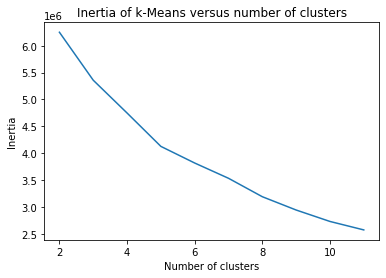

In [20]:
# Find the k for kmeans using elbow method
scores = [KMeans(n_clusters=i+2).fit(femaClusterDf).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [21]:
# Fit K-means using best value for k from above
kmeans = KMeans(n_clusters=3)
kmeans.fit(femaClusterDf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

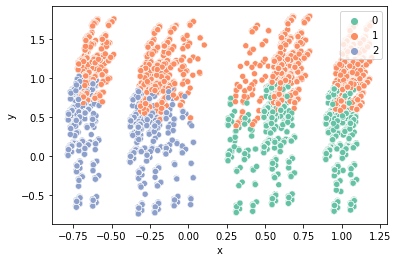

In [22]:
# Perform PCA for visualization in 2-D
def perform_pca(n_components, df, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(df)
    pca_df = pd.DataFrame(matrix)
    pca_df.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    pca_df['labels'] = kmeans_labels
    
    return pca_df

pca_df = perform_pca(3, femaClusterDf, kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")
plt.legend(loc='upper right')

In [ ]:
# Scale the columns for better visualization
# df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(femaClusterDf))
# df_scaled.columns = femaClusterDf.columns
# df_scaled['kmeans'] = kmeans.labels_

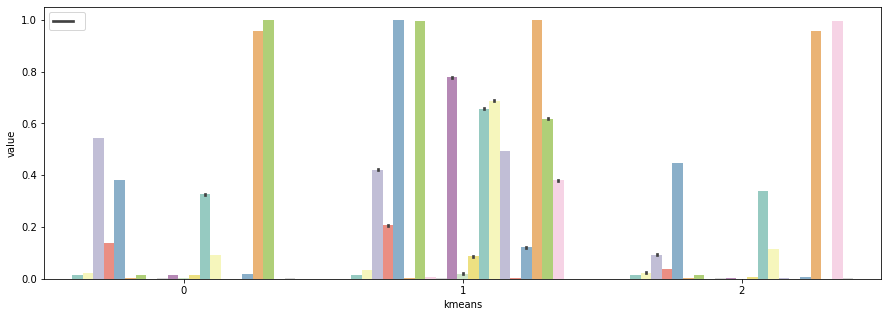

In [24]:
# Visualize the clusters, and variables
femaClusterDf['kmeans'] = kmeans.labels_
tidy = femaClusterDf.melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])

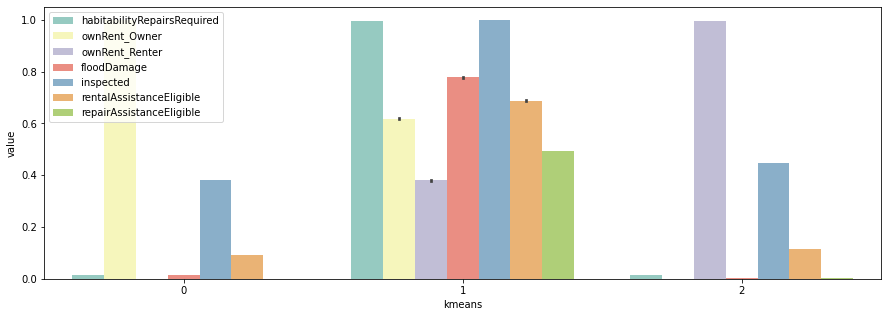

In [25]:
# Highlight the top features based on maximum variance across clusters
df_mean = femaClusterDf.groupby('kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['kmeans']

# Plot data
tidy = femaClusterDf[selected_columns].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')


### KMeans Clustering over boolean columns only

In [49]:
femaClusterDf_bool = femaClusterDf.loc[:, bool_cols]

In [50]:
femaClusterDf_bool.columns.tolist()

['specialNeeds',
 'homeOwnersInsurance',
 'floodInsurance',
 'inspected',
 'destroyed',
 'habitabilityRepairsRequired',
 'floodDamage',
 'foundationDamage',
 'roofDamage',
 'tsaEligible',
 'rentalAssistanceEligible',
 'repairAssistanceEligible',
 'replacementAssistanceEligible',
 'sbaEligible',
 'primaryResidence']

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

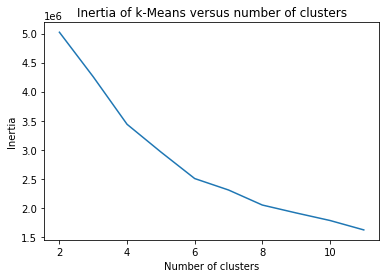

In [51]:
# Find the k for kmeans using elbow method
scores = [KMeans(n_clusters=i+2).fit(femaClusterDf_bool).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [52]:
# Fit K-means using best value for k from above
kmeans_bool = KMeans(n_clusters=3)
kmeans_bool.fit(femaClusterDf_bool)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

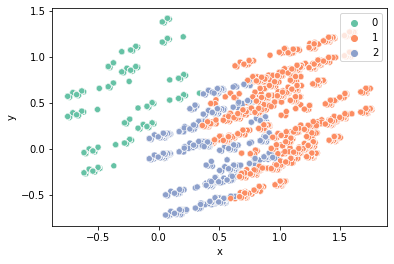

In [53]:
pca_df = perform_pca(3, femaClusterDf_bool, kmeans_bool.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")
plt.legend(loc='upper right')

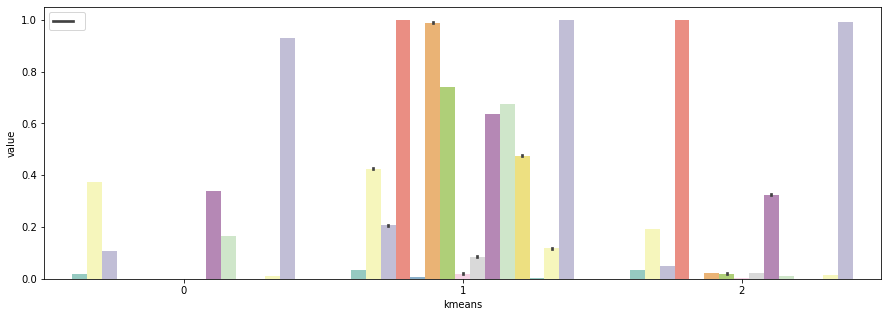

In [54]:
# Visualize the clusters, and variables
femaClusterDf_bool['kmeans'] = kmeans_bool.labels_
tidy = femaClusterDf_bool.melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])

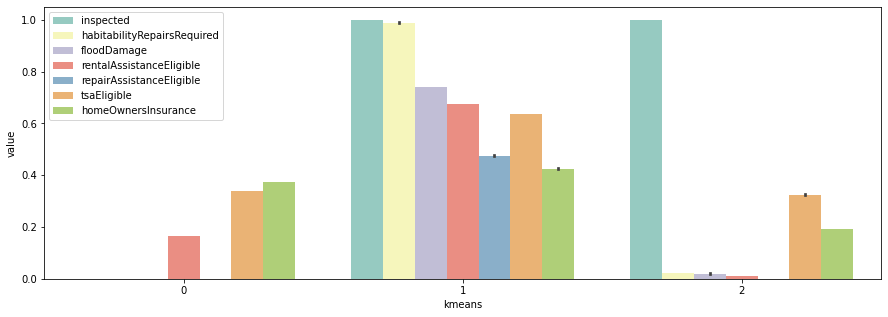

In [55]:
# Highlight the top features based on maximum variance across clusters
df_mean = femaClusterDf_bool.groupby('kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['kmeans']

# Plot data
tidy = femaClusterDf_bool[selected_columns].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')